In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tqdm

from sklearn.datasets import fetch_openml
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV 

from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss

We will use the leukemia dataset. A dataset of genetic data, the goal is to classify the type of leukemia. In this dataset, p>>n, then it is natural to think of a LASSO type regularization to handle this dataset

In [ ]:
print("Loading data...")
dataset = fetch_openml("leukemia")

X = dataset.data.astype(float)
y = (dataset.target!='ALL').astype(int)
print('Done !')
print('n = {}, p = {}'.format(X.shape[0], X.shape[1]))

Loading data...
Done !
n = 72, p = 7129


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5)
print('Train: {}, Test: {}'.format(X_train.shape[0], X_test.shape[0]))

Train; 36, Test: 36


# Classical Logistic regression
Let's first try with a logistic regression. 

In [ ]:
clf = LogisticRegression(penalty = 'none', solver = 'saga', max_iter=10000).fit(X_train, y_train)
print('Accuracy train: {:.2f}%'.format(clf.score(X_train, y_train)*100))
print('Accuracy test: {:.2f}%'.format(clf.score(X_test, y_test)*100))
print('Nb coeffs > 0: ', np.sum(clf.coef_>0))
print('Nb coeffs < 0: ', np.sum(clf.coef_<0))
print('Nb coeffs = 0: ', np.sum(clf.coef_==0))

Accuracy train: 100.00%
Accuracy test: 94.44%
Nb coeffs > 0:  3828
Nb coeffs < 0:  3301
Nb coeffs = 0:  0


Logistic Regression is great ! But all the features are used in the classification. It may be useful to select from these the one that are the most important, then we will try with a LASSO regularization.

# LASSO

In [ ]:
clf = LogisticRegression(penalty = 'l1', solver = 'liblinear', C = 1, max_iter=10000 ).fit(X_train, y_train)
print('Accuracy test: {:.2f}%'.format(clf.score(X_train, y_train)*100))
print('Accuracy test: {:.2f}%'.format(clf.score(X_test, y_test)*100))
print('Nb coeffs > 0: ', np.sum(clf.coef_>0))
print('Nb coeffs < 0: ', np.sum(clf.coef_<0))
print('Nb coeffs = 0: ', np.sum(clf.coef_==0))

Accuracy test: 100.00%
Accuracy test: 97.22%
Nb coeffs > 0:  121
Nb coeffs < 0:  115
Nb coeffs = 0:  6893


Lasso selects a few less parameters than a logistic regression without regularization. **Remark:** with a l1 regularization, you have to change for a liblinear solver (see doc). 
You can play around with the hyperparameters of the model to improve your results.


[Here](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression) is the doc for logistic regression.

# Hyperparameters finetuning: Homemade

The first simple idea to finetune automatically your hyperparameters is doing a grid search and using a validation set. Here we have only one hyperparameter, C.
The metric we use if the binary cross entropy (= negative log likelihood).

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  import sys


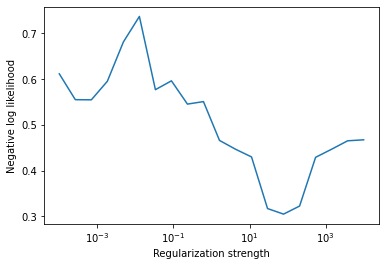

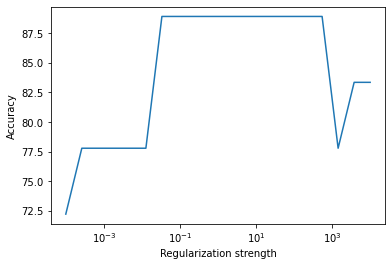

===============TEST with finetuned hyperparameters===============
Regularization strength selected:  78.47599703514607
Accuracy train: 100.00%
Accuracy test: 97.22%
Nb coeffs > 0:  935
Nb coeffs < 0:  875
Nb coeffs = 0:  5319


In [ ]:
val_losses = []
val_accs = []

X_train_reduce, X_val, y_train_reduce, y_val = train_test_split(X_train, y_train, test_size=0.5)
Cs = np.logspace(-4, 4, 20)

for C in tqdm.tqdm_notebook(Cs):
  clf = LogisticRegression(random_state=10, penalty = 'l1', solver = 'liblinear', C = C, max_iter=10000).fit(X_train_reduce, y_train_reduce)
  val_losses.append(log_loss(y_val, clf.predict_proba(X_val)[:,1]))
  val_accs.append(clf.score(X_val, y_val)*100)


plt.figure()
plt.plot(Cs, val_losses)
plt.xscale('log')
plt.xlabel('Regularization strength')
plt.ylabel('Negative log likelihood')
plt.show()

plt.figure()
plt.plot(Cs, val_accs)
plt.xscale('log')
plt.xlabel('Regularization strength')
plt.ylabel('Accuracy')
plt.show()

print('===============TEST with finetuned hyperparameters===============')

# Test:
C = Cs[np.array(val_losses).argmin()]
clf = LogisticRegression(random_state=10, penalty = 'l1', solver = 'liblinear', C = C, max_iter=10000).fit(X_train, y_train)
print("Regularization strength selected: ",  Cs[np.array(val_losses).argmin()])
print('Accuracy train: {:.2f}%'.format(clf.score(X_train, y_train)*100))
print('Accuracy test: {:.2f}%'.format(clf.score(X_test, y_test)*100))
print('Nb coeffs > 0: ', np.sum(clf.coef_>0))
print('Nb coeffs < 0: ', np.sum(clf.coef_<0))
print('Nb coeffs = 0: ', np.sum(clf.coef_==0))

# Hyperparameters finetuning: Cross validation

Second simple way to finetune your hyperparameters is by doing grid_search and croos validation simultanously. See [link](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegressionCV.html#sklearn.linear_model.LogisticRegressionCV) for info.

In [ ]:
clf = LogisticRegressionCV(cv = 8, penalty = 'l1', solver = 'liblinear', Cs = np.logspace(-4,4,25), max_iter=10000)
clf.fit(X_train, y_train)
print("Regularization strength selected: ", clf.C_[0])
print('Accuracy train: {:.2f}%'.format(clf.score(X_train, y_train)*100))
print('Accuracy test: {:.2f}%'.format(clf.score(X_test, y_test)*100))
print('Nb coeffs > 0: ', np.sum(clf.coef_>0))
print('Nb coeffs < 0: ', np.sum(clf.coef_<0))
print('Nb coeffs = 0: ', np.sum(clf.coef_==0))

Regularization strength selected:  21.54434690031882
Accuracy train: 100.00%
Accuracy test: 97.22%
Nb coeffs > 0:  676
Nb coeffs < 0:  570
Nb coeffs = 0:  5883


#Assignement

Repeat with elasticnet regularization and comment.


